In [13]:
# Imports

import bson 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.sparse import csr_matrix
from fonctions import *
from surprise import BaselineOnly, SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import KNNBasic, KNNWithMeans, NMF
from sklearn.neighbors import KNeighborsRegressor
from surprise.model_selection import GridSearchCV
import time





###################################################################################################

# Open and read the BSON files
with open("./trictrac/details.bson", "rb") as f:
    details = bson.decode_all(f.read())


with open("./trictrac/infos_scrapping.bson", "rb") as f:
    infos = bson.decode_all(f.read())

with open("./trictrac/jeux.bson", "rb") as f:
    jeux = bson.decode_all(f.read())


with open("./trictrac/avis.bson", "rb") as f:
    avis = bson.decode_all(f.read())

pdDetails = pd.DataFrame(details)
pdJeux = pd.DataFrame(jeux)
pdInfos = pd.DataFrame(infos)
pdAvis = pd.DataFrame(avis)

###################################################################################################
# Nettoyage

# Spam removable 
pdAvis['review_length'] = pdAvis['comment'].str.len()
pdAvis=pdAvis[pdAvis["review_length"] != 58097.0]

#Duplicates removable
pdAvis.drop_duplicates(subset=['author','title_review','note','title','comment'], inplace=True)
pdJeux.drop_duplicates(subset=['title',	'href','avis'], inplace=True)


allgames = sorted(pdJeux["title"].unique())
allusers = sorted(pdAvis['author'].unique())


# Création de la dataFrame  
ratings_matrix = pd.DataFrame(
    index=allusers,
    columns=allgames,
    dtype=float
)

# Remplissage de la matrice avec les notes
for _, row in pdAvis.iterrows():
    ratings_matrix.at[row['author'], row['title']] = row['note']

# Conversion en matrice sparse
mask = ~ratings_matrix.isna()
sparse_ratings_matrix = csr_matrix(
    (
        ratings_matrix.values[mask], 
        np.where(mask)
    ),
    shape=ratings_matrix.shape
)

# Remove users and games with with low numbers of ratings the optimal value found was (14,18)
from fonctions import minipingpong, subtract_mean
cleaned_matrix = minipingpong(sparse_ratings_matrix, allusers, allgames, 14, 18)


In [15]:
# Convert the cleaned_matrix data to Surprise format
ratings_list = []
for i, j in zip(*cleaned_matrix.nonzero()):
    user = allusers[i]
    game = allgames[j]
    rating = cleaned_matrix[i, j]
    ratings_list.append((user, game, rating))


ratings_df = pd.DataFrame(ratings_list, columns=['userID', 'itemID', 'rating'])

param_grid_knn = {
    'k': [  1,   4,   7,  10,  13,  16,  19,  22,  25,  28,  31,  34,  37,
        40, 46,  52,  61,   73, 
        79,  88,  91,  100,  109,
       118, 130, 133, 145, 148],
    'min_k': [2],
    'sim_options': {
        'name': ['cosine']

    }
}

# Define the reader with appropriate rating scale 
reader = Reader(rating_scale=(0, 10))

# Create a Surprise dataset
data = Dataset.load_from_df(ratings_df, reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)


gs_knn = GridSearchCV(KNNWithMeans, param_grid_knn, measures=['rmse', 'mae'], cv=3)
gs_knn.fit(data)

best_knn_params = gs_knn.best_params['rmse']
best_knn_score = gs_knn.best_score['rmse']
print(f"\nKNNWithMeans Best Parameters: {best_knn_params}")
print(f"RMSE: {best_knn_score:.4f}")

results_knn = []
for params, mean_rmse, mean_mae in zip(
        gs_knn.cv_results['params'],
        gs_knn.cv_results['mean_test_rmse'],
        gs_knn.cv_results['mean_test_mae']):
    results_knn.append({'params': params, 'mean_test_rmse': mean_rmse, 'mean_test_mae': mean_mae})
results_knn.sort(key=lambda x: x['mean_test_rmse'])

def print_grid_search_results(results, n_top=5):
    print(f"Top {n_top} parameter combinations:")
    for i, params in enumerate(results[:n_top]):
        print(f"{i+1}. {params['params']} - RMSE: {params['mean_test_rmse']:.4f}")

print_grid_search_results(results_knn)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

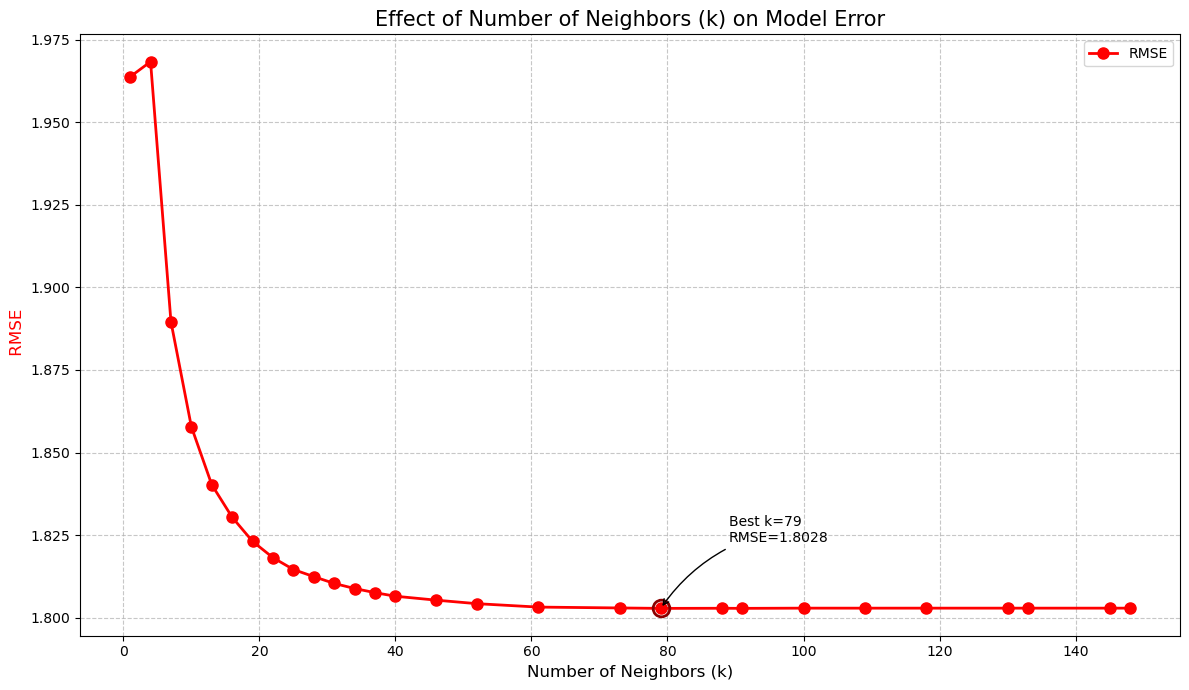

In [19]:
# Extract k values and corresponding RMSE values
k_values = []
rmse_values = []
mae_values = []
sorted_results = sorted(results_knn, key=lambda x: x['params']['k'])

for result in sorted_results:
    k_values.append(result['params']['k'])
    rmse_values.append(result['mean_test_rmse'])
    mae_values.append(result['mean_test_mae'])



plt.figure(figsize=(12, 7))

plt.plot(k_values, rmse_values, 'o-', color='red', linewidth=2, markersize=8, label='RMSE')


best_k = best_knn_params['k']
best_idx = k_values.index(best_k)
best_rmse = rmse_values[best_idx]


plt.plot(best_k, best_rmse, 'o', markersize=12, markerfacecolor='none', 
         markeredgewidth=2, markeredgecolor='darkred')


plt.annotate(f'Best k={best_k}\nRMSE={best_rmse:.4f}',
             xy=(best_k, best_rmse),
             xytext=(best_k+10, best_rmse+0.02),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'))

plt.title('Effect of Number of Neighbors (k) on Model Error', fontsize=15)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel(' RMSE', fontsize=12, color='red')
plt.grid(True, linestyle='--', alpha=0.7)

handles1, labels1 = plt.gca().get_legend_handles_labels()
plt.legend(handles1 , labels1 , loc='upper right')

plt.tight_layout()

### 

Computing the cosine similarity matrix...
Done computing similarity matrix.
Finding nearest neighbors for user: #yuyu#

Top 10 nearest neighbors for #yuyu#:
1. Behaine (Similarity: 1.0000)
2. Couthieu (Similarity: 1.0000)
3. David Cicurel (Similarity: 1.0000)
4. Blanche- (Similarity: 1.0000)
5. Ahranos (Similarity: 1.0000)
6. Didyme (Similarity: 1.0000)
7. Aquarius80 (Similarity: 1.0000)
8. Benwab (Similarity: 1.0000)
9. Alexis ANNE (Similarity: 1.0000)
10. Barracuda (Similarity: 1.0000)

Common games rated by #yuyu# and top neighbor Behaine:
Game                                     #yuyu#     Behaine   
------------------------------------------------------------
Biafra !                                 10.0       9.7       


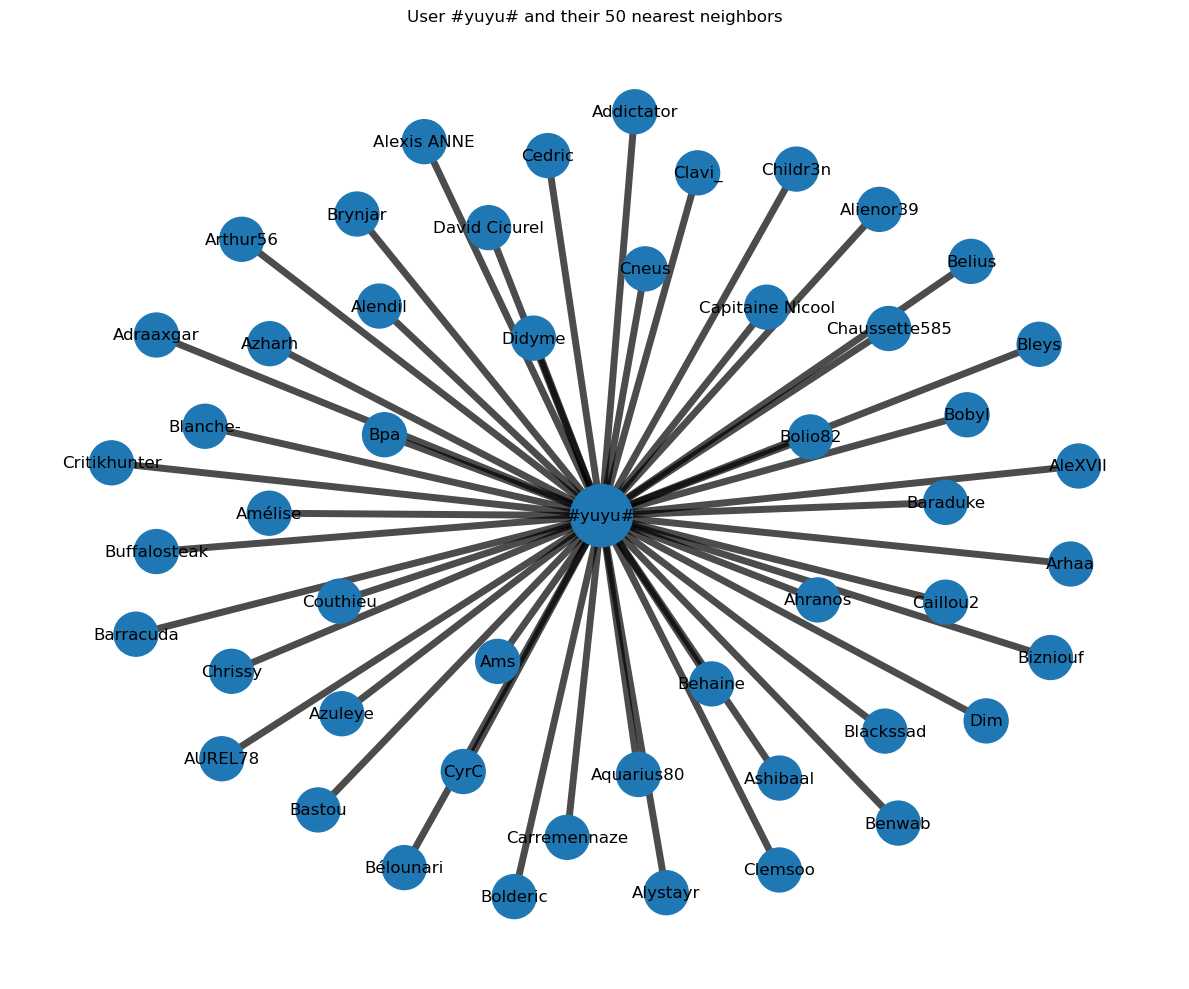

In [21]:
best_k = best_knn_params['k']
best_model = KNNWithMeans(
    k=best_k,
    min_k=2,
    sim_options={'name': 'cosine'}
)
best_model.fit(trainset)

def get_nearest_neighbors(model, user_id, n_neighbors=10):
    """
    Extract the n nearest neighbors for a given user.
    """
    # Check if user exists in the training set
    try:
        # This will raise an exception if the user is not in the training set
        inner_user_id = model.trainset.to_inner_uid(user_id)
    except ValueError:
        print(f"User {user_id} not found in training data")
        return []
    
    # Get the similarity matrix
    sim_matrix = model.sim
    
    # Get all other users and their similarity scores
    neighbors = []
    for other_inner_id in range(model.trainset.n_users):
        if other_inner_id != inner_user_id:
            similarity = sim_matrix[inner_user_id, other_inner_id]
            # Convert inner id back to raw id for readability
            other_user_id = model.trainset.to_raw_uid(other_inner_id)
            neighbors.append((other_user_id, similarity))
    
    # Sort by similarity (descending)
    neighbors.sort(key=lambda x: x[1], reverse=True)
    
    # Return top n neighbors
    return neighbors[:n_neighbors]

# Example usage:
user_id = allusers[0]  # Replace with a user ID of interest
print(f"Finding nearest neighbors for user: {user_id}")
neighbors = get_nearest_neighbors(best_model, user_id, n_neighbors=10)

# Display the results
if neighbors:
    print(f"\nTop 10 nearest neighbors for {user_id}:")
    for i, (neighbor, similarity) in enumerate(neighbors):
        print(f"{i+1}. {neighbor} (Similarity: {similarity:.4f})")
    
    # Optionally: Compare ratings between target user and top neighbor
    top_neighbor = neighbors[0][0]
    
    # Get games rated by both users
    target_user_ratings = {game: rating for game, rating in ratings_df[ratings_df['userID'] == user_id][['itemID', 'rating']].values}
    neighbor_ratings = {game: rating for game, rating in ratings_df[ratings_df['userID'] == top_neighbor][['itemID', 'rating']].values}
    
    common_games = set(target_user_ratings.keys()) & set(neighbor_ratings.keys())
    
    if common_games:
        print(f"\nCommon games rated by {user_id} and top neighbor {top_neighbor}:")
        print("{:<40} {:<10} {:<10}".format("Game", user_id, top_neighbor))
        print("-" * 60)
        for game in common_games:
            print("{:<40} {:<10.1f} {:<10.1f}".format(
                game[:38], target_user_ratings[game], neighbor_ratings[game]))

def visualize_user_similarity_network(model, user_id, n_neighbors=5):
    """Visualize the similarity network for a user and their neighbors"""
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors)
    
    import networkx as nx
    
    G = nx.Graph()
    G.add_node(user_id, size=20)
    
    # Add connections to neighbors
    for neighbor, similarity in neighbors:
        G.add_node(neighbor, size=10)
        G.add_edge(user_id, neighbor, weight=similarity*5)
    
    plt.figure(figsize=(12, 10))
    
    pos = nx.spring_layout(G)
    
    # Draw nodes
    node_sizes = [G.nodes[node]['size']*100 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
    
    # Draw edges with width based on similarity
    edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7)
    
    # Add labels
    nx.draw_networkx_labels(G, pos)
    
    plt.title(f"User {user_id} and their {n_neighbors} nearest neighbors")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
user_id = allusers[0]  # Replace with your user of interest
visualize_user_similarity_network(best_model, user_id, n_neighbors=50)

In [28]:
def get_neighbor_comments(model, user_id, n_neighbors=50, max_comments_per_neighbor=10):
    """
    Get comments from the nearest neighbors of a given user.
    
  
       output: Dictionary mapping neighbors to their comments
    """
    # Get nearest neighbors
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors)
    
    if not neighbors:
        return {}
    
    # Dictionary to store neighbor comments
    neighbor_comments = {}
    
    for neighbor_id, similarity in neighbors:
        # Get comments from this neighbor
        neighbor_reviews = pdAvis[pdAvis['author'] == neighbor_id]
        
        # Sort by note (highest first) to get most positive comments
        neighbor_reviews = neighbor_reviews.sort_values('note', ascending=False)
        
        # Get the top N comments
        top_comments = []
        for _, review in neighbor_reviews.iterrows():
            # Check if comment is a string before trying to get its length
            comment = review['comment']
            if isinstance(comment, str):
                comment_display = comment[:300] + "..." if len(comment) > 300 else comment
            else:
                comment_display = "No comment available"
                
            top_comments.append({
                'game': review['title'],
                'note': review['note'],
                'comment': comment_display,
                'title_review': review['title_review']
            })
        
        neighbor_comments[neighbor_id] = {
            'similarity': similarity,
            'comments': top_comments
        }
        
    return neighbor_comments

# Example usage
user_id = allusers[0]  # Replace with your user of interest
print(f"Finding comments from nearest neighbors for user: {user_id}")
neighbor_comments = get_neighbor_comments(best_model, user_id)

# Display the comments in a readable format
for neighbor_id, data in neighbor_comments.items():
    print(f"\n\n{'='*80}")
    print(f"Neighbor: {neighbor_id} (Similarity: {data['similarity']:.4f})")
    print(f"{'-'*80}")
    
    for i, comment_data in enumerate(data['comments']):
        print(f"\nComment {i+1} - Game: {comment_data['game']} (Rating: {comment_data['note']}/10)")
        print(f"Title: {comment_data['title_review']}")
        print(f"\n{comment_data['comment']}")
        print(f"{'-'*40}")

Finding comments from nearest neighbors for user: #yuyu#


Neighbor: Behaine (Similarity: 1.0000)
--------------------------------------------------------------------------------

Comment 1 - Game: World of Warcraft - Le jeu de plateau (Rating: 4.0/10)
Title: Comique de répétition...

Bon, tout n'est pas perdu avec ce jeu, loin de là. Le système de combat, l'évolution des personnages, le jeu par équipe... Il y a deux trois trucs bien foutus quand même.Mais ça reste laborieux. La fiche de personnage peut compter jusqu'à onze cartes compétences/talents, les combats peuvent vous fai...
----------------------------------------


Neighbor: Couthieu (Similarity: 1.0000)
--------------------------------------------------------------------------------

Comment 1 - Game: Outlive (Rating: 9.5/10)
Title: À posséder

No comment available
----------------------------------------

Comment 2 - Game: Argo (Rating: 9.3/10)
Title: Excellent jeu !!!!

J'y ai joué hier sur la version imprimable et après 1

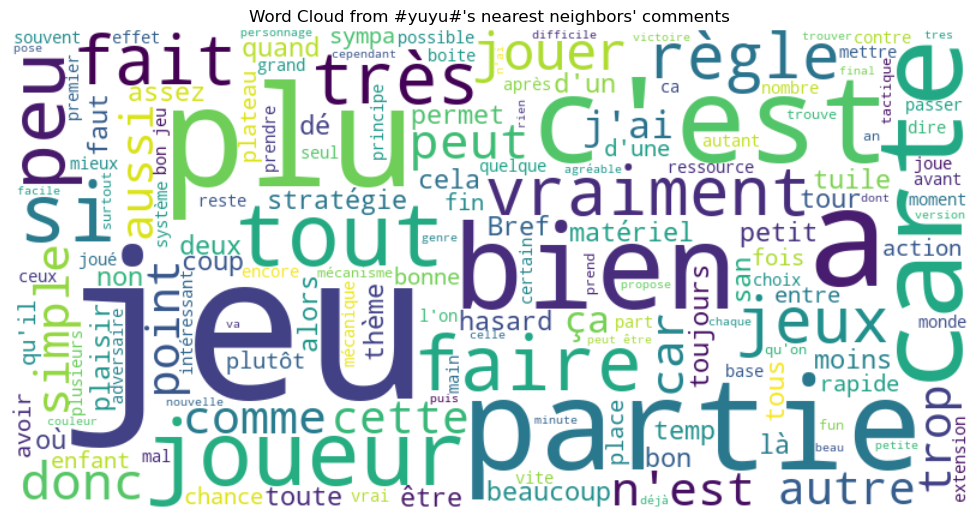

In [30]:
def create_neighbor_comment_wordcloud(model, user_id, n_neighbors=10, max_comments=50):
    """
    Create a word cloud from the comments of nearest neighbors.
    """
    # Get nearest neighbors
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors)
    
    if not neighbors:
        return
    
    # Combine all comments from neighbors
    neighbor_ids = [neighbor for neighbor, _ in neighbors]
    all_comments = pdAvis[pdAvis['author'].isin(neighbor_ids)]['comment'].tolist()
    
    # Filter out non-string comments and convert to strings if needed
    text_comments = []
    for comment in all_comments:
        if isinstance(comment, str):
            text_comments.append(comment)
        elif isinstance(comment, (int, float)) and not pd.isna(comment):
            # Convert numbers to strings if they're not NaN
            text_comments.append(str(comment))
    
    # Join all valid comments
    combined_text = " ".join(text_comments)
    
    # Generate word cloud
    from wordcloud import WordCloud
    import nltk
    from nltk.corpus import stopwords
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    
    # Get French stopwords
    stop_words = set(stopwords.words('french'))
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          stopwords=stop_words,
                          min_font_size=10).generate(combined_text)
    
    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud from {user_id}'s nearest neighbors' comments")
    plt.tight_layout(pad=0)
    plt.show()
# Example usage - you may need to install wordcloud with: pip install wordcloud
try:
    create_neighbor_comment_wordcloud(best_model, user_id, n_neighbors=50)
except ImportError:
    print("Please install wordcloud with: pip install wordcloud")

Using mean rating as threshold: 7.22
Found 366 high-rating reviews (≥7.223736600306279)
Found 287 low-rating reviews (<7.223736600306279)


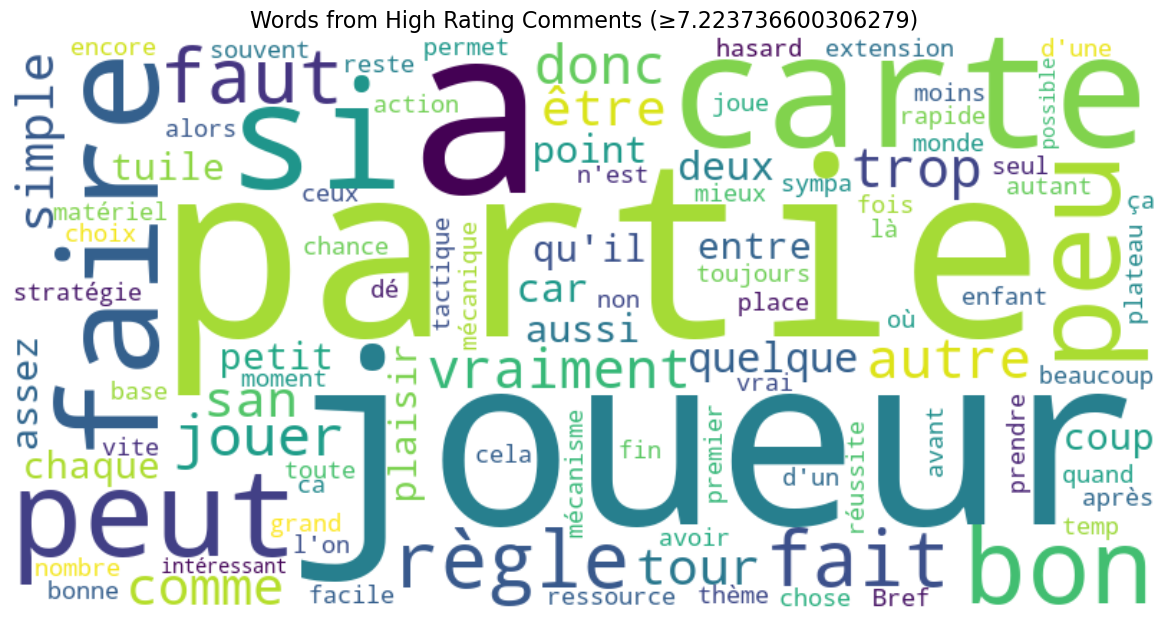

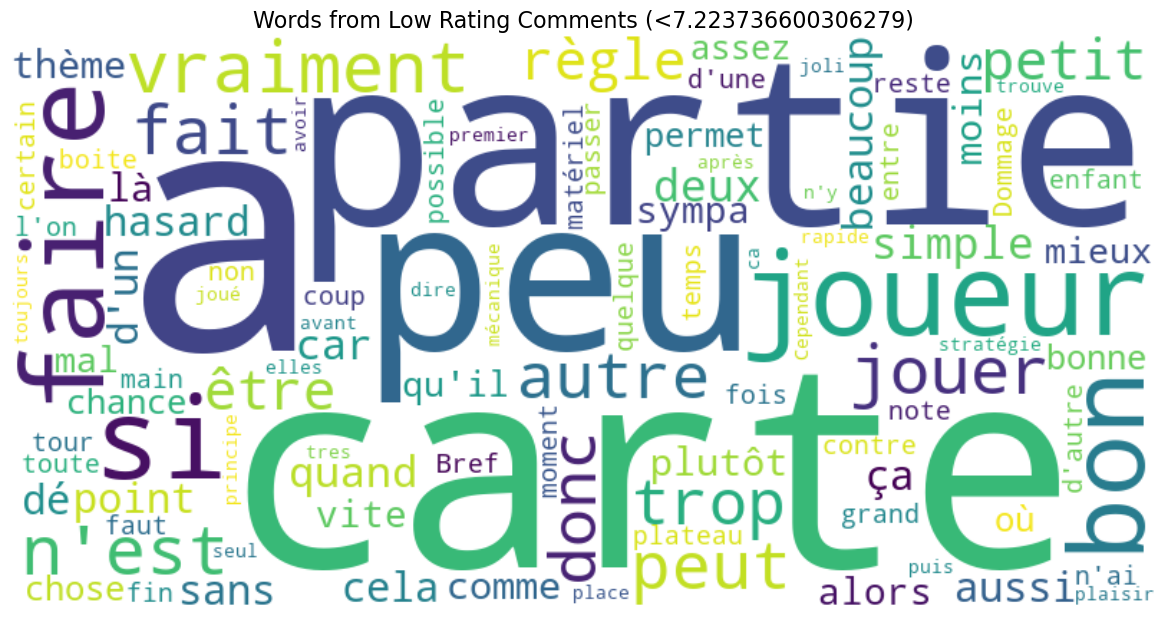


== Words ONLY in high-rating comments (count ≥ 5) ==
meilleur: 13
agricola: 13
riche: 12
belle: 11
greenville: 9
ffg: 9
posséder: 9
res: 8
scénario: 8
combinaisons: 8
dure: 8
edge: 8
adapter: 8
agit: 8
soirées: 7
peur: 7
arcana: 7
sent: 7
rebondissements: 7
nécessaire: 7
merveille: 7
parmi: 7
carcassonne: 7
originalité: 7
merci: 6
puisse: 6
conseille: 6
vivement: 6
placer: 6
année: 6

== Words ONLY in low-rating comments (count ≥ 5) ==
campagne: 7
statues: 7
mauvaise: 6
fantômes: 6
éliminer: 5
résultat: 5
pilote: 5
ennuyeux: 5
rester: 5

== Common words (with different usage patterns) ==
Word                 High Ratings    Low Ratings     Ratio High/Low 
joueurs              148             57              2.04           
cartes               103             74              1.09           
partie               116             59              1.54           
peu                  86              84              0.80           
faire                91              65              1.10  

<Figure size 1400x800 with 0 Axes>

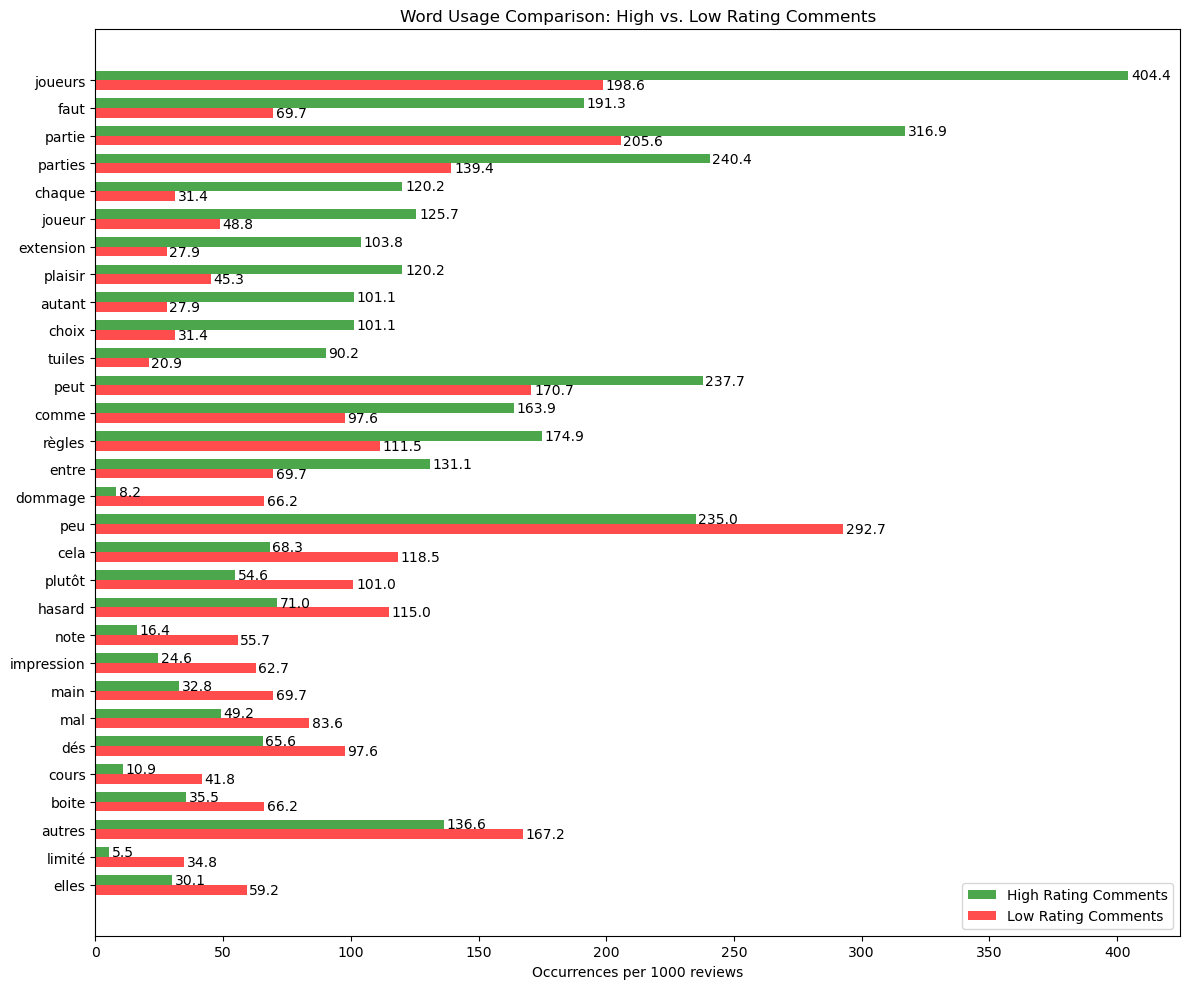

In [46]:
def compare_high_vs_low_rating_comments(model, user_id, n_neighbors=50, rating_threshold=None, min_word_count=5):
    """
    Compare word usage between high-rating and low-rating comments from neighbors.
    

        Minimum count for a word to be included in the comparison
    """
    # Get nearest neighbors
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors)
    
    if not neighbors:
        print(f"User {user_id} has no neighbors.")
        return
    
    # Get all comments from these neighbors
    neighbor_ids = [neighbor for neighbor, _ in neighbors]
    all_reviews = pdAvis[pdAvis['author'].isin(neighbor_ids)].copy()
    
    # If no threshold provided, use mean of all ratings
    if rating_threshold is None:
        rating_threshold = all_reviews['note'].mean()
        print(f"Using mean rating as threshold: {rating_threshold:.2f}")
    
    # Split reviews into high and low ratings
    high_rating_reviews = all_reviews[all_reviews['note'] >= min(rating_threshold,7.5)]
    low_rating_reviews = all_reviews[all_reviews['note'] < min(rating_threshold,7.5)]
    
    print(f"Found {len(high_rating_reviews)} high-rating reviews (≥{min(rating_threshold,7.5)})")
    print(f"Found {len(low_rating_reviews)} low-rating reviews (<{min(rating_threshold,7.5)})")
    
    # Function to process comments
    def process_comments(reviews):
        text_comments = []
        for comment in reviews['comment']:
            if isinstance(comment, str):
                text_comments.append(comment)
        return " ".join(text_comments)
    
    # Get combined text for each group
    high_rating_text = process_comments(high_rating_reviews)
    low_rating_text = process_comments(low_rating_reviews)
    
    # Generate word clouds
    from wordcloud import WordCloud
    import nltk
    from nltk.corpus import stopwords
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    
    # Get French stopwords
    stop_words = set(stopwords.words('french'))
    
    # Add custom stopwords common in reviews
    custom_stopwords = {"jeu", "jeux", "avis", "bien", "j'ai", "c'est", "très", "pour", "avec", 
                      "dans", "les", "des", "que", "qui", "est", "sont", "mais", "cette",
                      "vous", "plus", "tout", "tous", "ces", "ses", "vos", "nos"}
    stop_words.update(custom_stopwords)
    
    # Create word clouds
    def create_wordcloud(text, title, mask_color=None):
        if not text:
            print(f"No text available for {title}")
            return
            
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            stopwords=stop_words,
            max_words=100,
            collocations=False,
            min_font_size=10
        ).generate(text)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title, fontsize=16)
        plt.tight_layout(pad=0)
        plt.show()
    
    # Create the two word clouds
    create_wordcloud(high_rating_text, f"Words from High Rating Comments (≥{min(rating_threshold,7.5)})")
    create_wordcloud(low_rating_text, f"Words from Low Rating Comments (<{min(rating_threshold,7.5)})")
    
    # Extract word counts
    from collections import Counter
    import re
    
    def get_word_counts(text):
        # Simple tokenization (split on non-alphanumeric chars)
        words = re.findall(r'\b[a-zA-ZÀ-ÿ]{3,}\b', text.lower())
        # Filter out stopwords
        words = [word for word in words if word not in stop_words]
        # Return counter
        return Counter(words)
    
    # Get word counts for each category
    high_word_counts = get_word_counts(high_rating_text)
    low_word_counts = get_word_counts(low_rating_text)
    
    # Find words unique to high ratings, unique to low ratings, and common
    high_only_words = {word: count for word, count in high_word_counts.items() 
                      if count >= min_word_count and word not in low_word_counts}
    
    low_only_words = {word: count for word, count in low_word_counts.items() 
                     if count >= min_word_count and word not in high_word_counts}
    
    common_words = {word: (high_word_counts[word], low_word_counts[word]) 
                   for word in set(high_word_counts) & set(low_word_counts)
                   if high_word_counts[word] >= min_word_count and low_word_counts[word] >= min_word_count}
    
    # Sort results
    high_only_sorted = sorted(high_only_words.items(), key=lambda x: x[1], reverse=True)
    low_only_sorted = sorted(low_only_words.items(), key=lambda x: x[1], reverse=True)
    common_sorted = sorted(common_words.items(), key=lambda x: x[1][0] + x[1][1], reverse=True)
    
    # Display results
    print(f"\n== Words ONLY in high-rating comments (count ≥ {min_word_count}) ==")
    for word, count in high_only_sorted[:30]:  # Show top 30
        print(f"{word}: {count}")
    
    print(f"\n== Words ONLY in low-rating comments (count ≥ {min_word_count}) ==")
    for word, count in low_only_sorted[:30]:
        print(f"{word}: {count}")
    
    print("\n== Common words (with different usage patterns) ==")
    print("{:<20} {:<15} {:<15} {:<15}".format("Word", "High Ratings", "Low Ratings", "Ratio High/Low"))
    for word, (high_count, low_count) in common_sorted[:30]:
        # Calculate normalized ratio to account for different corpus sizes
        high_ratio = high_count / len(high_rating_reviews)
        low_ratio = low_count / len(low_rating_reviews)
        ratio = high_ratio / low_ratio if low_ratio > 0 else float('inf')
        
        print("{:<20} {:<15} {:<15} {:<15.2f}".format(
            word, high_count, low_count, ratio))
    
    # Create visualization of word differences
    plt.figure(figsize=(14, 8))
    
    # Generate data for visualization
    top_diff_words = []
    high_counts = []
    low_counts = []
    
    # Find words with the biggest difference in usage
    word_diffs = {}
    for word in set(high_word_counts) | set(low_word_counts):
        if word in high_word_counts and word in low_word_counts:
            # Normalize by number of reviews to adjust for dataset size differences
            high_ratio = high_word_counts[word] / len(high_rating_reviews)
            low_ratio = low_word_counts[word] / len(low_rating_reviews)
            word_diffs[word] = high_ratio - low_ratio
    
    # Get words with most extreme differences (both positive and negative)
    top_high_words = sorted(word_diffs.items(), key=lambda x: x[1], reverse=True)[:15]
    top_low_words = sorted(word_diffs.items(), key=lambda x: x[1])[:15]
    top_diff_items = top_high_words + top_low_words
    
    for word, _ in top_diff_items:
        top_diff_words.append(word)
        high_counts.append(high_word_counts.get(word, 0) / len(high_rating_reviews) * 1000)  # Per 1000 reviews
        low_counts.append(low_word_counts.get(word, 0) / len(low_rating_reviews) * 1000)  # Per 1000 reviews
    
    # Create horizontal bar chart
    y_pos = np.arange(len(top_diff_words))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 10))
    bars1 = ax.barh(y_pos - width/2, high_counts, width, label='High Rating Comments', color='green', alpha=0.7)
    bars2 = ax.barh(y_pos + width/2, low_counts, width, label='Low Rating Comments', color='red', alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_diff_words)
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_xlabel('Occurrences per 1000 reviews')
    ax.set_title('Word Usage Comparison: High vs. Low Rating Comments')
    ax.legend()
    
    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            width = bar.get_width()
            if width > 0:
                ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
                        f'{width:.1f}', ha='left', va='center')
    
    add_labels(bars1)
    add_labels(bars2)
    
    plt.tight_layout()
    plt.show()
    
    return high_word_counts, low_word_counts, common_words

# Example usage
user_id = allusers[0]  # Replace with your user of interest
high_words, low_words, common_words = compare_high_vs_low_rating_comments(best_model, user_id, n_neighbors=50, min_word_count=5)

# You can also specify a threshold
# compare_high_vs_low_rating_comments(best_model, user_id, rating_threshold=7.0, min_word_count=5)

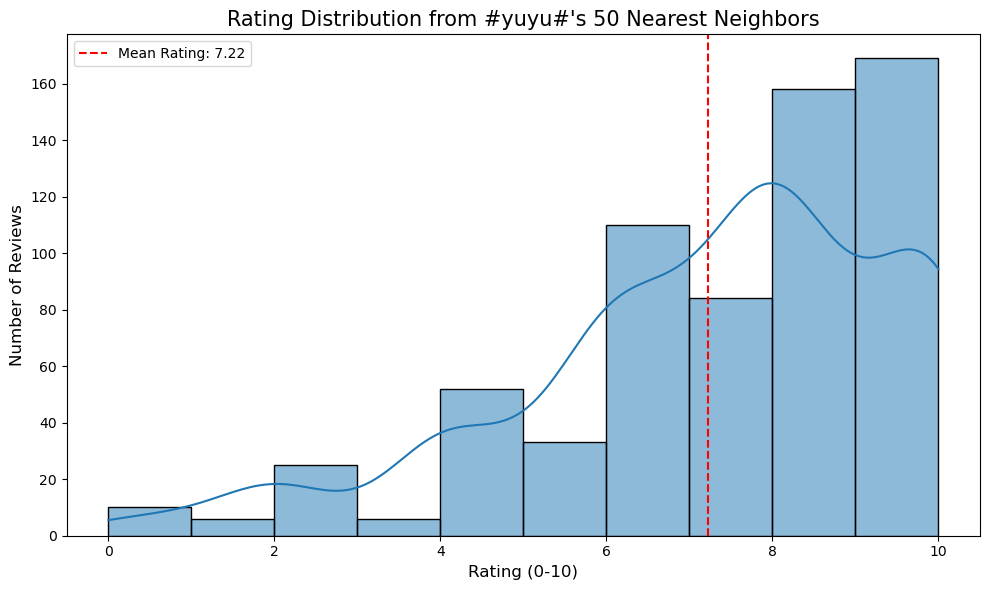

Mean rating: 7.22


In [47]:
def visualize_neighbor_rating_distribution(model, user_id, n_neighbors=50):
    """
    Visualize the distribution of ratings from a user's nearest neighbors
    """
    # Get nearest neighbors
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors)
    
    if not neighbors:
        print(f"User {user_id} has no neighbors.")
        return
        
    # Get all comments from these neighbors
    neighbor_ids = [neighbor for neighbor, _ in neighbors]
    all_reviews = pdAvis[pdAvis['author'].isin(neighbor_ids)].copy()
    
    # Plot histogram of ratings
    plt.figure(figsize=(10, 6))
    sns.histplot(all_reviews['note'], bins=10, kde=True)
    
    # Add vertical line for mean
    mean_rating = all_reviews['note'].mean()
    plt.axvline(mean_rating, color='red', linestyle='--', 
                label=f'Mean Rating: {mean_rating:.2f}')
    
    plt.title(f'Rating Distribution from {user_id}\'s {n_neighbors} Nearest Neighbors', fontsize=15)
    plt.xlabel('Rating (0-10)', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return mean_rating

# Example usage
mean_rating = visualize_neighbor_rating_distribution(best_model, user_id, n_neighbors=50)
print(f"Mean rating: {mean_rating:.2f}")

Analyzing 50 nearest and furthest neighbors for user #yuyu#
Nearest neighbor similarity range: 1.0000 to 1.0000
Furthest neighbor similarity range: 0.0000 to 0.0000
Found 653 reviews from nearest neighbors
Found 542 reviews from furthest neighbors


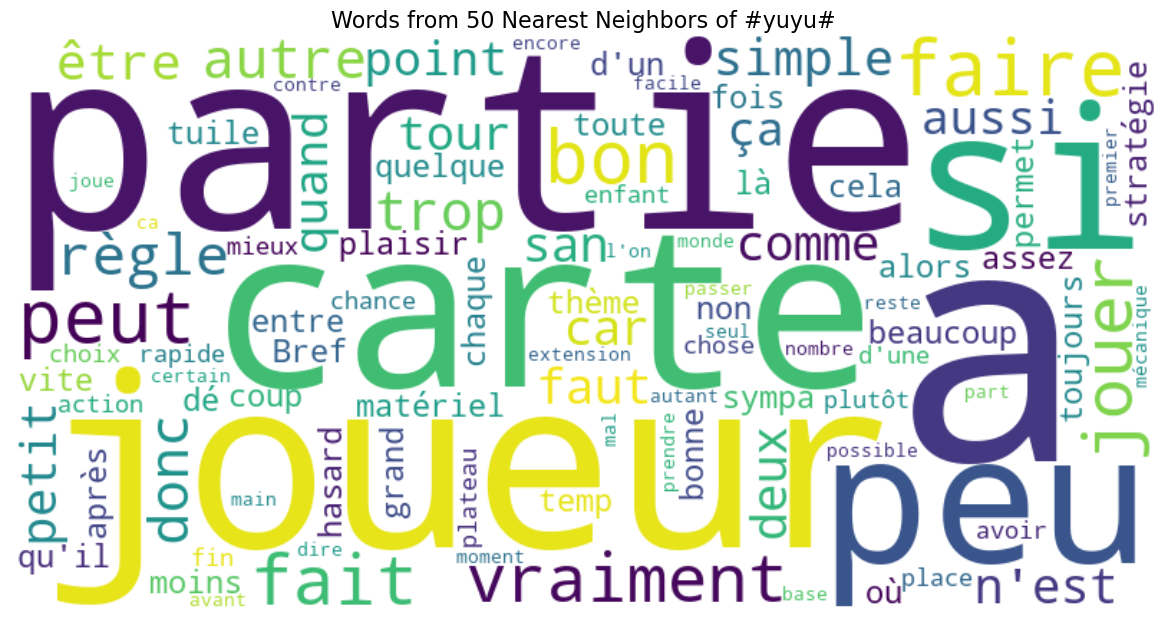

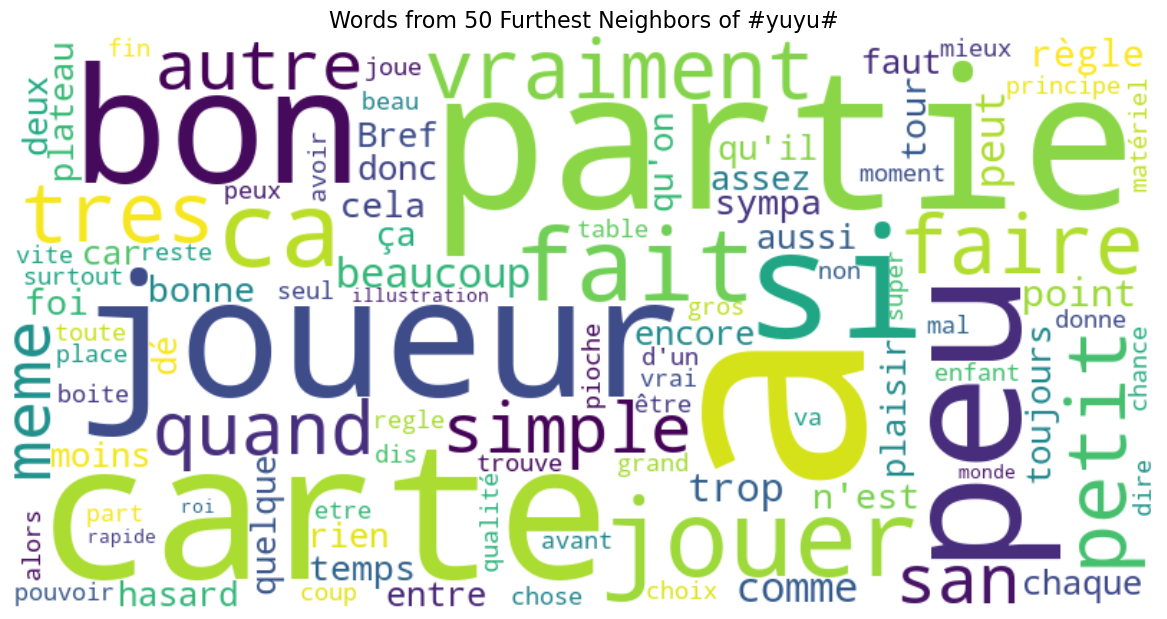


== Words ONLY from nearest neighbors (count ≥ 5) ==
indices: 11
expérience: 11
world: 10
greenville: 9
près: 9
principal: 9
ffg: 9
small: 8
res: 8
cités: 8
récolter: 8
utilisation: 8
dure: 8
edge: 8
fans: 8
quant: 8
collaboratif: 7
oeuvre: 7
arcana: 7
signe: 7
influence: 7
campagne: 7
apparaissent: 7
souvenirs: 7
considérablement: 7
statues: 7
cherchais: 6
potes: 6
inverse: 6
option: 6

== Words ONLY from furthest neighbors (count ≥ 5) ==
theme: 25
mecanique: 18
deviens: 17
bcp: 15
drole: 15
gout: 14
regle: 14
façile: 14
depart: 12
strategique: 10
gardes: 10
encheres: 10
rigolade: 9
strategie: 9
thematique: 9
château: 9
assassins: 9
cote: 8
reflexion: 8
forcement: 8
villes: 8
finallement: 8
etait: 8
pieces: 8
lisible: 7
hic: 7
eviter: 7
hesiter: 7
calme: 7
arrêter: 7

== Common words (with different usage patterns) ==
Word                 Nearest         Furthest        Ratio Near/Far 
tres                 29              128             0.19           
meme                 12        

<Figure size 1400x800 with 0 Axes>

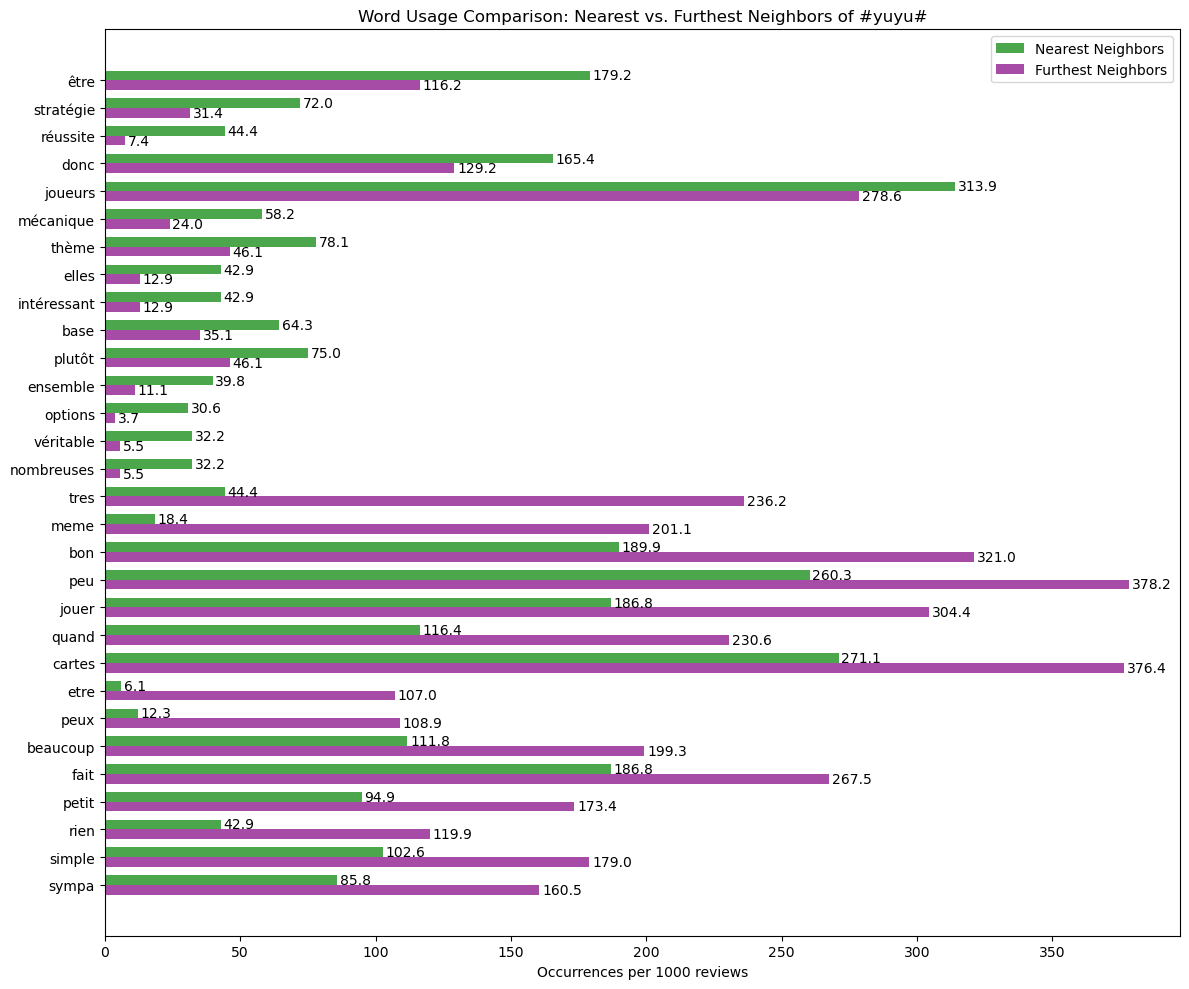

In [48]:
def compare_nearest_vs_furthest_comments(model, user_id, n_neighbors=50, min_word_count=5):
    """
    Compare word usage between nearest neighbors and furthest neighbors.
    
    Parameters:
    -----------
    model : KNNWithMeans model
        The trained model
    user_id : str
        The user ID to analyze
    n_neighbors : int
        Number of neighbors to include in each group
    min_word_count : int
        Minimum count for a word to be included in the comparison
    """
    # Check if user exists in the training set
    try:
        inner_user_id = model.trainset.to_inner_uid(user_id)
    except ValueError:
        print(f"User {user_id} not found in training data")
        return
    
    # Get the similarity matrix
    sim_matrix = model.sim
    
    # Get all other users and their similarity scores
    all_similarities = []
    for other_inner_id in range(model.trainset.n_users):
        if other_inner_id != inner_user_id:
            similarity = sim_matrix[inner_user_id, other_inner_id]
            # Convert inner id back to raw id for readability
            other_user_id = model.trainset.to_raw_uid(other_inner_id)
            all_similarities.append((other_user_id, similarity))
    
    # Sort by similarity (descending and ascending)
    all_similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Get nearest and furthest neighbors
    nearest_neighbors = all_similarities[:n_neighbors]
    furthest_neighbors = all_similarities[-n_neighbors:]
    
    print(f"Analyzing {n_neighbors} nearest and furthest neighbors for user {user_id}")
    print(f"Nearest neighbor similarity range: {nearest_neighbors[0][1]:.4f} to {nearest_neighbors[-1][1]:.4f}")
    print(f"Furthest neighbor similarity range: {furthest_neighbors[0][1]:.4f} to {furthest_neighbors[-1][1]:.4f}")
    
    # Get IDs for both groups
    nearest_ids = [neighbor for neighbor, _ in nearest_neighbors]
    furthest_ids = [neighbor for neighbor, _ in furthest_neighbors]
    
    # Get comments from both groups
    nearest_reviews = pdAvis[pdAvis['author'].isin(nearest_ids)].copy()
    furthest_reviews = pdAvis[pdAvis['author'].isin(furthest_ids)].copy()
    
    print(f"Found {len(nearest_reviews)} reviews from nearest neighbors")
    print(f"Found {len(furthest_reviews)} reviews from furthest neighbors")
    
    # Function to process comments
    def process_comments(reviews):
        text_comments = []
        for comment in reviews['comment']:
            if isinstance(comment, str):
                text_comments.append(comment)
        return " ".join(text_comments)
    
    # Get combined text for each group
    nearest_text = process_comments(nearest_reviews)
    furthest_text = process_comments(furthest_reviews)
    
    # Generate word clouds
    from wordcloud import WordCloud
    import nltk
    from nltk.corpus import stopwords
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    
    # Get French stopwords
    stop_words = set(stopwords.words('french'))
    
    # Add custom stopwords common in reviews
    custom_stopwords = {"jeu", "jeux", "avis", "bien", "j'ai", "c'est", "très", "pour", "avec", 
                      "dans", "les", "des", "que", "qui", "est", "sont", "mais", "cette",
                      "vous", "plus", "tout", "tous", "ces", "ses", "vos", "nos"}
    stop_words.update(custom_stopwords)
    
    # Create word clouds
    def create_wordcloud(text, title):
        if not text:
            print(f"No text available for {title}")
            return
            
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            stopwords=stop_words,
            max_words=100,
            collocations=False,
            min_font_size=10
        ).generate(text)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title, fontsize=16)
        plt.tight_layout(pad=0)
        plt.show()
    
    # Create the two word clouds
    create_wordcloud(nearest_text, f"Words from {n_neighbors} Nearest Neighbors of {user_id}")
    create_wordcloud(furthest_text, f"Words from {n_neighbors} Furthest Neighbors of {user_id}")
    
    # Extract word counts
    from collections import Counter
    import re
    
    def get_word_counts(text):
        # Simple tokenization (split on non-alphanumeric chars)
        words = re.findall(r'\b[a-zA-ZÀ-ÿ]{3,}\b', text.lower())
        # Filter out stopwords
        words = [word for word in words if word not in stop_words]
        # Return counter
        return Counter(words)
    
    # Get word counts for each category
    nearest_word_counts = get_word_counts(nearest_text)
    furthest_word_counts = get_word_counts(furthest_text)
    
    # Find words unique to nearest, unique to furthest, and common
    nearest_only_words = {word: count for word, count in nearest_word_counts.items() 
                      if count >= min_word_count and word not in furthest_word_counts}
    
    furthest_only_words = {word: count for word, count in furthest_word_counts.items() 
                     if count >= min_word_count and word not in nearest_word_counts}
    
    common_words = {word: (nearest_word_counts[word], furthest_word_counts[word]) 
                   for word in set(nearest_word_counts) & set(furthest_word_counts)
                   if nearest_word_counts[word] >= min_word_count and furthest_word_counts[word] >= min_word_count}
    
    # Sort results
    nearest_only_sorted = sorted(nearest_only_words.items(), key=lambda x: x[1], reverse=True)
    furthest_only_sorted = sorted(furthest_only_words.items(), key=lambda x: x[1], reverse=True)
    common_sorted = sorted(common_words.items(), key=lambda x: abs(x[1][0]/len(nearest_reviews) - x[1][1]/len(furthest_reviews)), reverse=True)
    
    # Display results
    print(f"\n== Words ONLY from nearest neighbors (count ≥ {min_word_count}) ==")
    for word, count in nearest_only_sorted[:30]:  # Show top 30
        print(f"{word}: {count}")
    
    print(f"\n== Words ONLY from furthest neighbors (count ≥ {min_word_count}) ==")
    for word, count in furthest_only_sorted[:30]:
        print(f"{word}: {count}")
    
    print("\n== Common words (with different usage patterns) ==")
    print("{:<20} {:<15} {:<15} {:<15}".format("Word", "Nearest", "Furthest", "Ratio Near/Far"))
    for word, (nearest_count, furthest_count) in common_sorted[:30]:
        # Calculate normalized ratio to account for different corpus sizes
        nearest_ratio = nearest_count / len(nearest_reviews)
        furthest_ratio = furthest_count / len(furthest_reviews)
        ratio = nearest_ratio / furthest_ratio if furthest_ratio > 0 else float('inf')
        
        print("{:<20} {:<15} {:<15} {:<15.2f}".format(
            word, nearest_count, furthest_count, ratio))
    
    # Create visualization of word differences
    plt.figure(figsize=(14, 8))
    
    # Generate data for visualization
    top_diff_words = []
    nearest_counts = []
    furthest_counts = []
    
    # Find words with the biggest difference in usage
    word_diffs = {}
    for word in set(nearest_word_counts) | set(furthest_word_counts):
        if word in nearest_word_counts and word in furthest_word_counts:
            # Normalize by number of reviews to adjust for dataset size differences
            nearest_ratio = nearest_word_counts[word] / len(nearest_reviews)
            furthest_ratio = furthest_word_counts[word] / len(furthest_reviews)
            word_diffs[word] = nearest_ratio - furthest_ratio
    
    # Get words with most extreme differences (both positive and negative)
    top_nearest_words = sorted(word_diffs.items(), key=lambda x: x[1], reverse=True)[:15]
    top_furthest_words = sorted(word_diffs.items(), key=lambda x: x[1])[:15]
    top_diff_items = top_nearest_words + top_furthest_words
    
    for word, _ in top_diff_items:
        top_diff_words.append(word)
        nearest_counts.append(nearest_word_counts.get(word, 0) / len(nearest_reviews) * 1000)  # Per 1000 reviews
        furthest_counts.append(furthest_word_counts.get(word, 0) / len(furthest_reviews) * 1000)  # Per 1000 reviews
    
    # Create horizontal bar chart
    y_pos = np.arange(len(top_diff_words))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 10))
    bars1 = ax.barh(y_pos - width/2, nearest_counts, width, label='Nearest Neighbors', color='green', alpha=0.7)
    bars2 = ax.barh(y_pos + width/2, furthest_counts, width, label='Furthest Neighbors', color='purple', alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_diff_words)
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_xlabel('Occurrences per 1000 reviews')
    ax.set_title(f'Word Usage Comparison: Nearest vs. Furthest Neighbors of {user_id}')
    ax.legend()
    
    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            width = bar.get_width()
            if width > 0:
                ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
                        f'{width:.1f}', ha='left', va='center')
    
    add_labels(bars1)
    add_labels(bars2)
    
    plt.tight_layout()
    plt.show()
    
    return nearest_word_counts, furthest_word_counts, common_words

# Example usage
user_id = allusers[0]  # Replace with your user of interest
nearest_words, furthest_words, common_words = compare_nearest_vs_furthest_comments(best_model, user_id, n_neighbors=50, min_word_count=5)

Found 579 games with enough positive and negative reviews:
Game Title                               Total Reviews   Positive Reviews Mean Rating    
-------------------------------------------------------------------------------------
Dead of Winter                           3               2               8.67           
Ricochet Robots                          3               1               7.33           
Majesty : une couronne pour le royaume   3               2               6.73           
Clank!                                   3               2               8.47           
Service Compris !                        3               2               5.27           
MasterMind - Le cadeau de César          3               1               4.67           
Yams / Yahtzee                           3               1               7.20           
Jeu de Tarot - Le Domaine des Dieux      3               2               7.57           
Discoveries : the Journals of Lewis &    2           

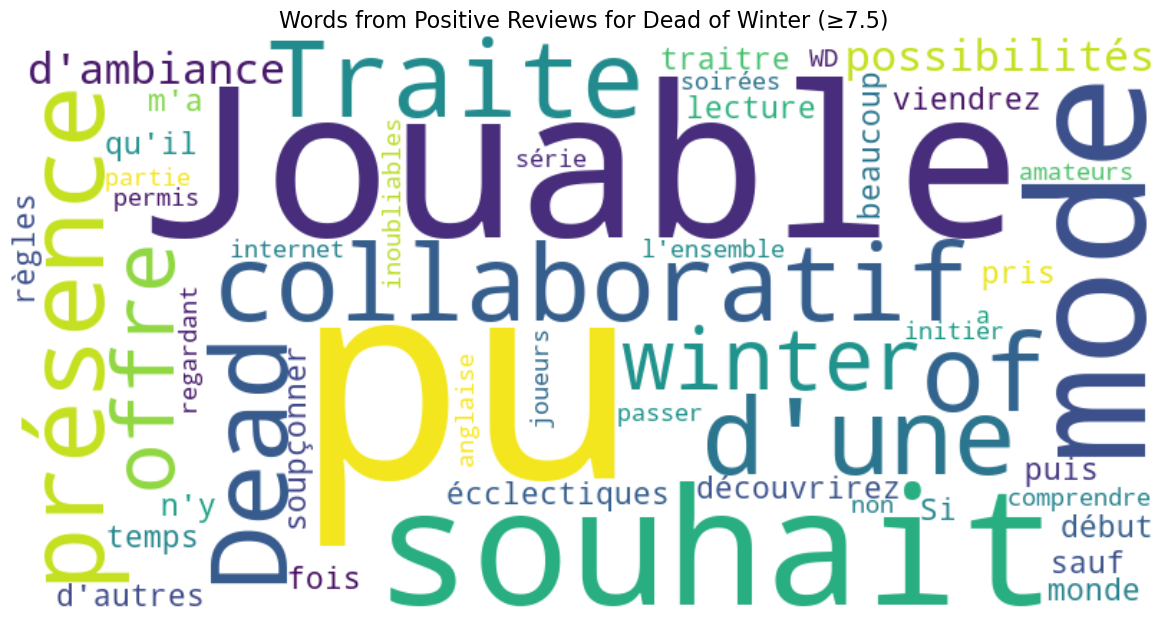

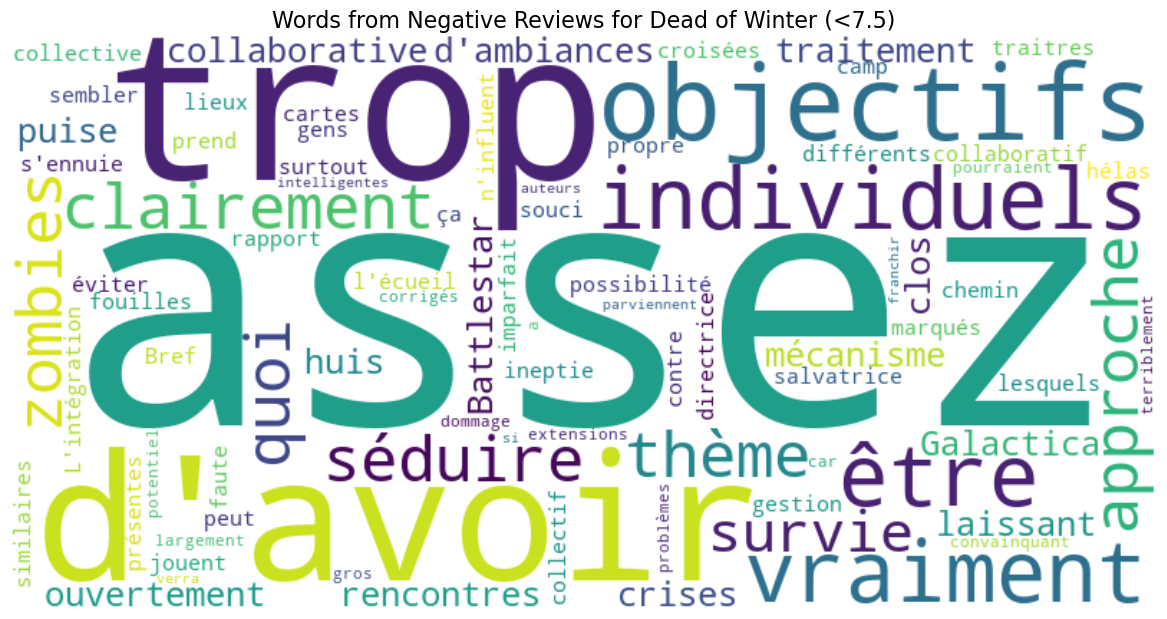


== Words ONLY in positive reviews for Dead of Winter (count ≥ 3) ==

== Words ONLY in negative reviews for Dead of Winter (count ≥ 3) ==
assez: 4
trop: 3

== Common words in reviews for Dead of Winter (with different usage patterns) ==
Word                 Positive        Negative        Ratio Pos/Neg  


<Figure size 1400x800 with 0 Axes>

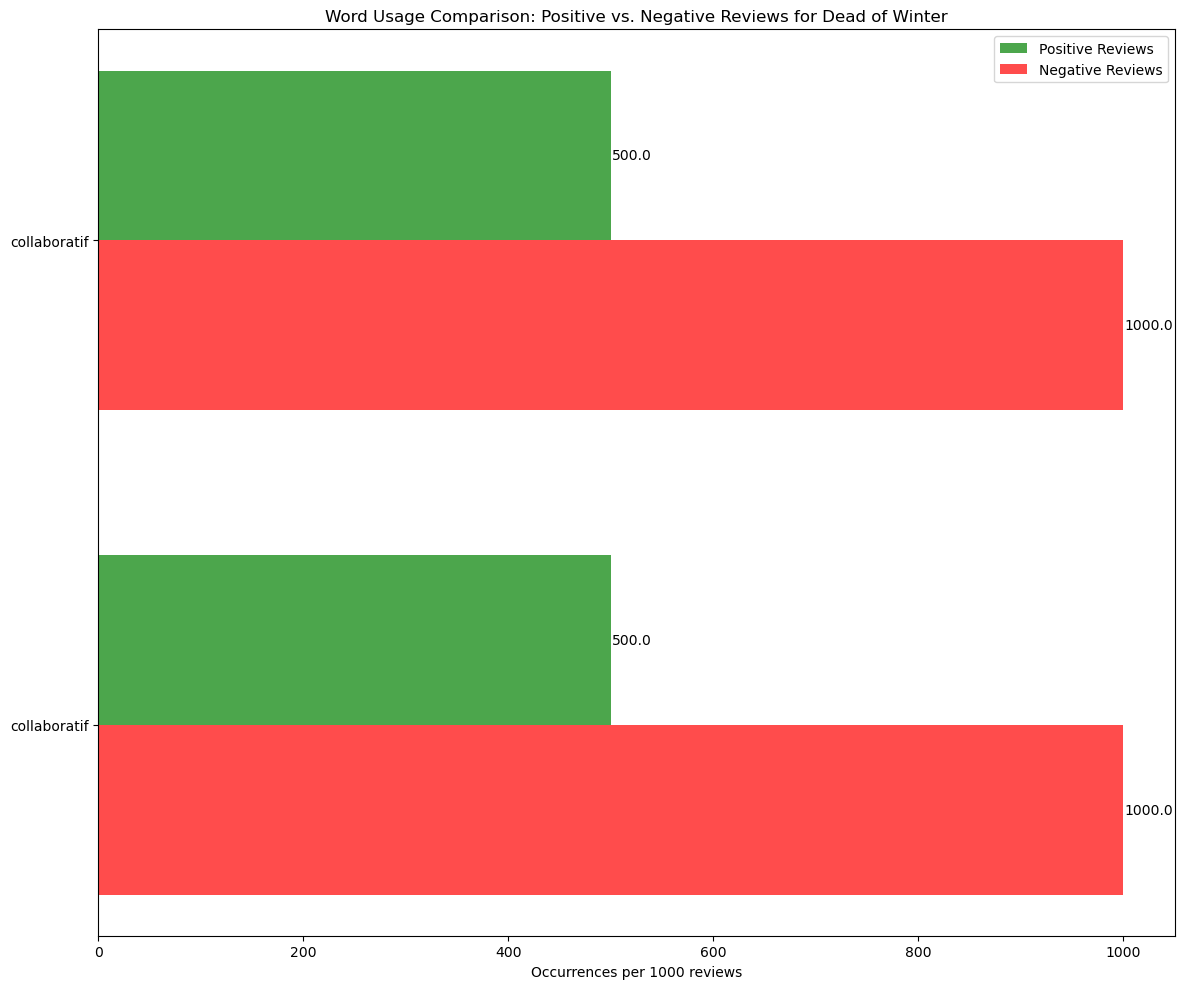

In [49]:
def compare_game_specific_comments(model, user_id, game_title, n_neighbors=50, rating_threshold=None, min_word_count=3):
    """
    Compare word usage between high-rating and low-rating comments from neighbors for a specific game.
    
    Parameters:
    -----------
    model : KNNWithMeans model
        The trained model
    user_id : str
        The user ID to analyze neighbors for
    game_title : str
        Title of the specific game to analyze
    n_neighbors : int
        Number of neighbors to include
    rating_threshold : float or None
        Rating threshold to separate high/low ratings
        If None, use the mean rating for this game
    min_word_count : int
        Minimum count for a word to be included in the comparison
    """
    # Get nearest neighbors
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors)
    
    if not neighbors:
        print(f"User {user_id} has no neighbors.")
        return
    
    # Get all comments from these neighbors for the specific game
    neighbor_ids = [neighbor for neighbor, _ in neighbors]
    
    # Filter comments for the specific game
    game_reviews = pdAvis[(pdAvis['author'].isin(neighbor_ids)) & 
                           (pdAvis['title'] == game_title)].copy()
    
    if game_reviews.empty:
        print(f"No reviews found for game '{game_title}' from nearest neighbors of {user_id}.")
        return
    
    # If no threshold provided, use mean of game ratings
    if rating_threshold is None:
        rating_threshold = game_reviews['note'].mean()
        print(f"Using mean rating as threshold: {rating_threshold:.2f}")
    
    # Split reviews into high and low ratings
    high_rating_reviews = game_reviews[game_reviews['note'] >= min(rating_threshold,7.5)]
    low_rating_reviews = game_reviews[game_reviews['note'] < min(rating_threshold,7.5)]
    
    print(f"Found {len(high_rating_reviews)} high-rating reviews (≥{min(rating_threshold,7.5)}) for {game_title}")
    print(f"Found {len(low_rating_reviews)} low-rating reviews (<{min(rating_threshold,7.5)}) for {game_title}")
    
    if high_rating_reviews.empty or low_rating_reviews.empty:
        print("Cannot compare reviews - need both positive and negative reviews.")
        return
    
    # Function to process comments
    def process_comments(reviews):
        text_comments = []
        for comment in reviews['comment']:
            if isinstance(comment, str):
                text_comments.append(comment)
        return " ".join(text_comments)
    
    # Get combined text for each group
    high_rating_text = process_comments(high_rating_reviews)
    low_rating_text = process_comments(low_rating_reviews)
    
    # Generate word clouds
    from wordcloud import WordCloud
    import nltk
    from nltk.corpus import stopwords
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    
    # Get French stopwords
    stop_words = set(stopwords.words('french'))
    
    # Add custom stopwords common in reviews
    custom_stopwords = {"jeu", "jeux", "avis", "bien", "j'ai", "c'est", "très", "pour", "avec", 
                      "dans", "les", "des", "que", "qui", "est", "sont", "mais", "cette",
                      "vous", "plus", "tout", "tous", "ces", "ses", "vos", "nos", game_title.lower()}
    stop_words.update(custom_stopwords)
    
    # Create word clouds
    def create_wordcloud(text, title, mask_color=None):
        if not text:
            print(f"No text available for {title}")
            return
            
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            stopwords=stop_words,
            max_words=100,
            collocations=False,
            min_font_size=10
        ).generate(text)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title, fontsize=16)
        plt.tight_layout(pad=0)
        plt.show()
    
    # Create the two word clouds
    create_wordcloud(high_rating_text, f"Words from Positive Reviews for {game_title} (≥{min(rating_threshold,7.5)})")
    create_wordcloud(low_rating_text, f"Words from Negative Reviews for {game_title} (<{min(rating_threshold,7.5)})")
    
    # Extract word counts
    from collections import Counter
    import re
    
    def get_word_counts(text):
        # Simple tokenization (split on non-alphanumeric chars)
        words = re.findall(r'\b[a-zA-ZÀ-ÿ]{3,}\b', text.lower())
        # Filter out stopwords
        words = [word for word in words if word not in stop_words]
        # Return counter
        return Counter(words)
    
    # Get word counts for each category
    high_word_counts = get_word_counts(high_rating_text)
    low_word_counts = get_word_counts(low_rating_text)
    
    # Find words unique to high ratings, unique to low ratings, and common
    high_only_words = {word: count for word, count in high_word_counts.items() 
                      if count >= min_word_count and word not in low_word_counts}
    
    low_only_words = {word: count for word, count in low_word_counts.items() 
                     if count >= min_word_count and word not in high_word_counts}
    
    common_words = {word: (high_word_counts[word], low_word_counts[word]) 
                   for word in set(high_word_counts) & set(low_word_counts)
                   if high_word_counts[word] >= min_word_count and low_word_counts[word] >= min_word_count}
    
    # Sort results
    high_only_sorted = sorted(high_only_words.items(), key=lambda x: x[1], reverse=True)
    low_only_sorted = sorted(low_only_words.items(), key=lambda x: x[1], reverse=True)
    common_sorted = sorted(common_words.items(), 
                          key=lambda x: abs((x[1][0]/len(high_rating_reviews)) - 
                                           (x[1][1]/len(low_rating_reviews))), 
                          reverse=True)
    
    # Display results
    print(f"\n== Words ONLY in positive reviews for {game_title} (count ≥ {min_word_count}) ==")
    for word, count in high_only_sorted[:30]:  # Show top 30
        print(f"{word}: {count}")
    
    print(f"\n== Words ONLY in negative reviews for {game_title} (count ≥ {min_word_count}) ==")
    for word, count in low_only_sorted[:30]:
        print(f"{word}: {count}")
    
    print(f"\n== Common words in reviews for {game_title} (with different usage patterns) ==")
    print("{:<20} {:<15} {:<15} {:<15}".format("Word", "Positive", "Negative", "Ratio Pos/Neg"))
    for word, (high_count, low_count) in common_sorted[:30]:
        # Calculate normalized ratio to account for different corpus sizes
        high_ratio = high_count / len(high_rating_reviews)
        low_ratio = low_count / len(low_rating_reviews)
        ratio = high_ratio / low_ratio if low_ratio > 0 else float('inf')
        
        print("{:<20} {:<15} {:<15} {:<15.2f}".format(
            word, high_count, low_count, ratio))
    
    # Create visualization of word differences
    plt.figure(figsize=(14, 8))
    
    # Generate data for visualization
    top_diff_words = []
    high_counts = []
    low_counts = []
    
    # Find words with the biggest difference in usage
    word_diffs = {}
    for word in set(high_word_counts) | set(low_word_counts):
        if word in high_word_counts and word in low_word_counts:
            # Normalize by number of reviews to adjust for dataset size differences
            high_ratio = high_word_counts[word] / len(high_rating_reviews)
            low_ratio = low_word_counts[word] / len(low_rating_reviews)
            word_diffs[word] = high_ratio - low_ratio
    
    # Get words with most extreme differences (both positive and negative)
    top_high_words = sorted(word_diffs.items(), key=lambda x: x[1], reverse=True)[:15]
    top_low_words = sorted(word_diffs.items(), key=lambda x: x[1])[:15]
    top_diff_items = top_high_words + top_low_words
    
    for word, _ in top_diff_items:
        top_diff_words.append(word)
        high_counts.append(high_word_counts.get(word, 0) / len(high_rating_reviews) * 1000)  # Per 1000 reviews
        low_counts.append(low_word_counts.get(word, 0) / len(low_rating_reviews) * 1000)  # Per 1000 reviews
    
    # Create horizontal bar chart
    y_pos = np.arange(len(top_diff_words))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 10))
    bars1 = ax.barh(y_pos - width/2, high_counts, width, label='Positive Reviews', color='green', alpha=0.7)
    bars2 = ax.barh(y_pos + width/2, low_counts, width, label='Negative Reviews', color='red', alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_diff_words)
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_xlabel('Occurrences per 1000 reviews')
    ax.set_title(f'Word Usage Comparison: Positive vs. Negative Reviews for {game_title}')
    ax.legend()
    
    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            width = bar.get_width()
            if width > 0:
                ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
                        f'{width:.1f}', ha='left', va='center')
    
    add_labels(bars1)
    add_labels(bars2)
    
    plt.tight_layout()
    plt.show()
    
    return high_word_counts, low_word_counts, common_words

# Helper function to find a game with enough reviews for analysis
def find_analyzable_games(model, user_id, n_neighbors=50, min_reviews=5):
    """Find games with enough positive and negative reviews from neighbors"""
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors)
    
    if not neighbors:
        print(f"User {user_id} has no neighbors.")
        return []
    
    neighbor_ids = [neighbor for neighbor, _ in neighbors]
    neighbor_reviews = pdAvis[pdAvis['author'].isin(neighbor_ids)]
    
    # Count reviews per game
    game_counts = neighbor_reviews['title'].value_counts()
    candidate_games = game_counts[game_counts >= min_reviews].index.tolist()
    
    results = []
    for game in candidate_games:
        game_reviews = neighbor_reviews[neighbor_reviews['title'] == game]
        mean_rating = game_reviews['note'].mean()
        pos_count = (game_reviews['note'] >= mean_rating).sum()
        neg_count = (game_reviews['note'] < mean_rating).sum()
        
        if pos_count >= min_reviews//2 and neg_count >= min_reviews//2:
            results.append({
                'title': game,
                'total_reviews': len(game_reviews),
                'positive_reviews': pos_count,
                'negative_reviews': neg_count,
                'mean_rating': mean_rating
            })
    
    # Sort by total reviews
    results.sort(key=lambda x: x['total_reviews'], reverse=True)
    return results

# Example usage
user_id = allusers[0]  # Replace with your user of interest
analyzable_games = find_analyzable_games(best_model, user_id, n_neighbors=50, min_reviews=10)

if analyzable_games:
    print(f"Found {len(analyzable_games)}")
def compare_game_specific_comments(model, user_id, game_title, n_neighbors=50, rating_threshold=None, min_word_count=3):
   
    # Get nearest neighbors
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors)
    
    if not neighbors:
        print(f"User {user_id} has no neighbors.")
        return
    
    # Get all comments from these neighbors for the specific game
    neighbor_ids = [neighbor for neighbor, _ in neighbors]
    
    # Filter comments for the specific game
    game_reviews = pdAvis[(pdAvis['author'].isin(neighbor_ids)) & 
                           (pdAvis['title'] == game_title)].copy()
    
    if game_reviews.empty:
        print(f"No reviews found for game '{game_title}' from nearest neighbors of {user_id}.")
        return
    
    # If no threshold provided, use mean of game ratings
    if rating_threshold is None:
        rating_threshold = game_reviews['note'].mean()
        print(f"Using mean rating as threshold: {rating_threshold:.2f}")
    
    # Split reviews into high and low ratings
    high_rating_reviews = game_reviews[game_reviews['note'] >= min(rating_threshold,7.5)]
    low_rating_reviews = game_reviews[game_reviews['note'] < min(rating_threshold,7.5)]
    
    print(f"Found {len(high_rating_reviews)} high-rating reviews (≥{min(rating_threshold,7.5)}) for {game_title}")
    print(f"Found {len(low_rating_reviews)} low-rating reviews (<{min(rating_threshold,7.5)}) for {game_title}")
    
    if high_rating_reviews.empty or low_rating_reviews.empty:
        print("Cannot compare reviews - need both positive and negative reviews.")
        return
    
    # Function to process comments
    def process_comments(reviews):
        text_comments = []
        for comment in reviews['comment']:
            if isinstance(comment, str):
                text_comments.append(comment)
        return " ".join(text_comments)
    
    # Get combined text for each group
    high_rating_text = process_comments(high_rating_reviews)
    low_rating_text = process_comments(low_rating_reviews)
    
    # Generate word clouds
    from wordcloud import WordCloud
    import nltk
    from nltk.corpus import stopwords
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    
    # Get French stopwords
    stop_words = set(stopwords.words('french'))
    
    # Add custom stopwords common in reviews
    custom_stopwords = {"jeu", "jeux", "avis", "bien", "j'ai", "c'est", "très", "pour", "avec", 
                      "dans", "les", "des", "que", "qui", "est", "sont", "mais", "cette",
                      "vous", "plus", "tout", "tous", "ces", "ses", "vos", "nos", game_title.lower()}
    stop_words.update(custom_stopwords)
    
    # Create word clouds
    def create_wordcloud(text, title, mask_color=None):
        if not text:
            print(f"No text available for {title}")
            return
            
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            stopwords=stop_words,
            max_words=100,
            collocations=False,
            min_font_size=10
        ).generate(text)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title, fontsize=16)
        plt.tight_layout(pad=0)
        plt.show()
    
    # Create the two word clouds
    create_wordcloud(high_rating_text, f"Words from Positive Reviews for {game_title} (≥{min(rating_threshold,7.5)})")
    create_wordcloud(low_rating_text, f"Words from Negative Reviews for {game_title} (<{min(rating_threshold,7.5)})")
    
    # Extract word counts
    from collections import Counter
    import re
    
    def get_word_counts(text):
        # Simple tokenization (split on non-alphanumeric chars)
        words = re.findall(r'\b[a-zA-ZÀ-ÿ]{3,}\b', text.lower())
        # Filter out stopwords
        words = [word for word in words if word not in stop_words]
        # Return counter
        return Counter(words)
    
    # Get word counts for each category
    high_word_counts = get_word_counts(high_rating_text)
    low_word_counts = get_word_counts(low_rating_text)
    
    # Find words unique to high ratings, unique to low ratings, and common
    high_only_words = {word: count for word, count in high_word_counts.items() 
                      if count >= min_word_count and word not in low_word_counts}
    
    low_only_words = {word: count for word, count in low_word_counts.items() 
                     if count >= min_word_count and word not in high_word_counts}
    
    common_words = {word: (high_word_counts[word], low_word_counts[word]) 
                   for word in set(high_word_counts) & set(low_word_counts)
                   if high_word_counts[word] >= min_word_count and low_word_counts[word] >= min_word_count}
    
    # Sort results
    high_only_sorted = sorted(high_only_words.items(), key=lambda x: x[1], reverse=True)
    low_only_sorted = sorted(low_only_words.items(), key=lambda x: x[1], reverse=True)
    common_sorted = sorted(common_words.items(), 
                          key=lambda x: abs((x[1][0]/len(high_rating_reviews)) - 
                                           (x[1][1]/len(low_rating_reviews))), 
                          reverse=True)
    
    # Display results
    print(f"\n== Words ONLY in positive reviews for {game_title} (count ≥ {min_word_count}) ==")
    for word, count in high_only_sorted[:30]:  # Show top 30
        print(f"{word}: {count}")
    
    print(f"\n== Words ONLY in negative reviews for {game_title} (count ≥ {min_word_count}) ==")
    for word, count in low_only_sorted[:30]:
        print(f"{word}: {count}")
    
    print(f"\n== Common words in reviews for {game_title} (with different usage patterns) ==")
    print("{:<20} {:<15} {:<15} {:<15}".format("Word", "Positive", "Negative", "Ratio Pos/Neg"))
    for word, (high_count, low_count) in common_sorted[:30]:
        # Calculate normalized ratio to account for different corpus sizes
        high_ratio = high_count / len(high_rating_reviews)
        low_ratio = low_count / len(low_rating_reviews)
        ratio = high_ratio / low_ratio if low_ratio > 0 else float('inf')
        
        print("{:<20} {:<15} {:<15} {:<15.2f}".format(
            word, high_count, low_count, ratio))
    
    # Create visualization of word differences
    plt.figure(figsize=(14, 8))
    
    # Generate data for visualization
    top_diff_words = []
    high_counts = []
    low_counts = []
    
    # Find words with the biggest difference in usage
    word_diffs = {}
    for word in set(high_word_counts) | set(low_word_counts):
        if word in high_word_counts and word in low_word_counts:
            # Normalize by number of reviews to adjust for dataset size differences
            high_ratio = high_word_counts[word] / len(high_rating_reviews)
            low_ratio = low_word_counts[word] / len(low_rating_reviews)
            word_diffs[word] = high_ratio - low_ratio
    
    # Get words with most extreme differences (both positive and negative)
    top_high_words = sorted(word_diffs.items(), key=lambda x: x[1], reverse=True)[:15]
    top_low_words = sorted(word_diffs.items(), key=lambda x: x[1])[:15]
    top_diff_items = top_high_words + top_low_words
    
    for word, _ in top_diff_items:
        top_diff_words.append(word)
        high_counts.append(high_word_counts.get(word, 0) / len(high_rating_reviews) * 1000)  # Per 1000 reviews
        low_counts.append(low_word_counts.get(word, 0) / len(low_rating_reviews) * 1000)  # Per 1000 reviews
    
    # Create horizontal bar chart
    y_pos = np.arange(len(top_diff_words))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 10))
    bars1 = ax.barh(y_pos - width/2, high_counts, width, label='Positive Reviews', color='green', alpha=0.7)
    bars2 = ax.barh(y_pos + width/2, low_counts, width, label='Negative Reviews', color='red', alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_diff_words)
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_xlabel('Occurrences per 1000 reviews')
    ax.set_title(f'Word Usage Comparison: Positive vs. Negative Reviews for {game_title}')
    ax.legend()
    
    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            width = bar.get_width()
            if width > 0:
                ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
                        f'{width:.1f}', ha='left', va='center')
    
    add_labels(bars1)
    add_labels(bars2)
    
    plt.tight_layout()
    plt.show()
    
    return high_word_counts, low_word_counts, common_words

# Helper function to find a game with enough reviews for analysis
def find_analyzable_games(model, user_id, n_neighbors=50, min_reviews=5):
    """Find games with enough positive and negative reviews from neighbors"""
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors)
    
    if not neighbors:
        print(f"User {user_id} has no neighbors.")
        return []
    
    neighbor_ids = [neighbor for neighbor, _ in neighbors]
    neighbor_reviews = pdAvis[pdAvis['author'].isin(neighbor_ids)]
    
    # Count reviews per game
    game_counts = neighbor_reviews['title'].value_counts()
    candidate_games = game_counts[game_counts >= min_reviews].index.tolist()
    
    results = []
    for game in candidate_games:
        game_reviews = neighbor_reviews[neighbor_reviews['title'] == game]
        mean_rating = game_reviews['note'].mean()
        pos_count = (game_reviews['note'] >= mean_rating).sum()
        neg_count = (game_reviews['note'] < mean_rating).sum()
        
        if pos_count >= min_reviews//2 and neg_count >= min_reviews//2:
            results.append({
                'title': game,
                'total_reviews': len(game_reviews),
                'positive_reviews': pos_count,
                'negative_reviews': neg_count,
                'mean_rating': mean_rating
            })
    
    # Sort by total reviews
    results.sort(key=lambda x: x['total_reviews'], reverse=True)
    return results


def analyze_game_reviews_for_user(model, user_id, n_neighbors=50, min_reviews=10):
    """
    Find analyzable games and display their statistics for a user's neighbors
    
    Parameters:
    -----------
    model : KNNWithMeans model
        The trained model
    user_id : str
        The user ID to analyze neighbors for
    n_neighbors : int
        Number of neighbors to include
    min_reviews : int
        Minimum number of reviews required for a game to be analyzed
    """
    analyzable_games = find_analyzable_games(model, user_id, n_neighbors, min_reviews)
    
    if not analyzable_games:
        print(f"No games with enough positive and negative reviews found for {user_id}'s neighbors")
        return None
    
    print(f"Found {len(analyzable_games)} games with enough positive and negative reviews:")
    print("{:<40} {:<15} {:<15} {:<15}".format("Game Title", "Total Reviews", "Positive Reviews", "Mean Rating"))
    print("-" * 85)
    
    for game_data in analyzable_games[:20]:  # Show top 20
        print("{:<40} {:<15} {:<15} {:<15.2f}".format(
            game_data['title'][:38], 
            game_data['total_reviews'],
            game_data['positive_reviews'],
            game_data['mean_rating']
        ))
    
    return analyzable_games

# Example usage
user_id = allusers[0]  # Replace with your user of interest
analyzable_games = analyze_game_reviews_for_user(best_model, user_id, n_neighbors=50, min_reviews=1)

# If games are found, analyze the most reviewed one
if analyzable_games:
    most_reviewed_game = analyzable_games[0]['title']
    print(f"\nAnalyzing the most reviewed game: {most_reviewed_game}")
    high_words, low_words, common_words = compare_game_specific_comments(
        best_model, user_id, most_reviewed_game, n_neighbors=50, min_word_count=3
    )

In [ ]:
def generate_recommendation_explanation(model, user_id, game_id, n_neighbors=5, min_similarity=0.2):
    """
    Generate a human-readable explanation for why a game is recommended to a user
    based on nearest neighbors' reviews.
    
    Parameters:
    -----------
    model : KNNWithMeans model
        The trained model
    user_id : str
        The user ID receiving the recommendation
    game_id : str
        The game being recommended
    n_neighbors : int
        Number of similar users to consider
    min_similarity : float
        Minimum similarity threshold for considering a neighbor
    
    Returns:
    --------
    dict : A dictionary containing explanation components and supporting data
    """
    # Get nearest neighbors
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors=n_neighbors*3)
    
    # Filter by minimum similarity
    neighbors = [(n_id, sim) for n_id, sim in neighbors if sim >= min_similarity]
    
    if not neighbors:
        return {
            "success": False,
            "message": f"No sufficiently similar users found for {user_id}"
        }
    
    # Find neighbors who rated this game
    game_reviews = pdAvis[(pdAvis['author'].isin([n for n, _ in neighbors])) & 
                         (pdAvis['title'] == game_id)]
    
    if game_reviews.empty:
        return {
            "success": False,
            "message": f"None of {user_id}'s similar users have reviewed {game_id}"
        }
    
    # Sort reviews by neighbor similarity (not by rating)
    game_reviews = game_reviews.copy()
    game_reviews['neighbor_similarity'] = game_reviews['author'].apply(
        lambda x: next(sim for n, sim in neighbors if n == x)
    )
    game_reviews = game_reviews.sort_values('neighbor_similarity', ascending=False)
    
    # Get positive and negative reviews
    mean_rating = game_reviews['note'].mean()
    positive_reviews = game_reviews[game_reviews['note'] >= mean_rating]
    negative_reviews = game_reviews[game_reviews['note'] < mean_rating]
    
    # Extract key phrases
    pos_phrases = extract_key_phrases(positive_reviews) if not positive_reviews.empty else []
    neg_phrases = extract_key_phrases(negative_reviews) if not negative_reviews.empty else []
    
    # Pick most important neighbor comments
    top_positive = get_top_comments(positive_reviews, n=2)
    top_negative = get_top_comments(negative_reviews, n=1)
    
    # Calculate overall metrics
    pos_count = len(positive_reviews)
    neg_count = len(negative_reviews)
    total = pos_count + neg_count
    
    positive_percentage = pos_count / total * 100 if total > 0 else 0
    avg_rating = game_reviews['note'].mean()
    
    # Generate explanation text
    if positive_percentage >= 70:
        sentiment = "very positive"
    elif positive_percentage >= 60:
        sentiment = "generally positive"
    elif positive_percentage >= 40:
        sentiment = "mixed"
    else:
        sentiment = "generally negative"
        
    explanation = {
        "success": True,
        "game_id": game_id,
        "user_id": user_id,
        "sentiment": sentiment,
        "similar_users_count": len(game_reviews['author'].unique()),
        "positive_count": pos_count,
        "negative_count": neg_count,
        "avg_rating": avg_rating,
        "key_positive_phrases": pos_phrases[:5],
        "key_negative_phrases": neg_phrases[:3],
        "top_positive_comments": top_positive,
        "top_negative_comments": top_negative
    }
    
    return explanation

def extract_key_phrases(reviews, n=5):
    """Extract key phrases from reviews using simple frequency analysis"""
    from collections import Counter
    import re
    import nltk
    from nltk.corpus import stopwords
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
        
    # Get French stopwords
    stop_words = set(stopwords.words('french'))
    
    # Add custom stopwords common in reviews
    custom_stopwords = {"jeu", "jeux", "avis", "bien", "j'ai", "c'est", "très", "pour", "avec", 
                      "dans", "les", "des", "que", "qui", "est", "sont", "mais", "cette",
                      "vous", "plus", "tout", "tous", "ces", "ses", "vos", "nos"}
    stop_words.update(custom_stopwords)
    
    # Combine all review text
    all_text = " ".join([str(text) for text in reviews['comment'] if isinstance(text, str)])
    
    # Find 2-3 word phrases (simple approach)
    words = re.findall(r'\b[a-zA-ZÀ-ÿ]{3,}\b', all_text.lower())
    words = [word for word in words if word not in stop_words]
    
    # Count frequencies
    word_counts = Counter(words)
    
    # Return most common phrases
    return [phrase for phrase, _ in word_counts.most_common(n)]

def get_top_comments(reviews, n=2):
    """Get the most representative comments from reviews"""
    if len(reviews) == 0:
        return []
    
    # Sort by a combination of similarity and note (higher is better)
    scored_reviews = reviews.copy()
    if 'neighbor_similarity' in scored_reviews.columns:
        scored_reviews['score'] = scored_reviews['neighbor_similarity'] * (scored_reviews['note'] / 5)
        scored_reviews = scored_reviews.sort_values('score', ascending=False)
    
    # Return best comments with shortened text
    result = []
    for _, review in scored_reviews.head(n).iterrows():
        comment = review['comment']
        if isinstance(comment, str):
            # Limit comment length and add ellipsis
            if len(comment) > 200:
                comment = comment[:200] + "..."
        else:
            comment = "No comment text available"
            
        result.append({
            'author': review['author'],
            'rating': review['note'],
            'comment': comment,
            'title': review.get('title_review', 'No title')
        })
    
    return result

def present_recommendation_explanation(explanation, include_negative=True):
    """
    Present a recommendation explanation in a user-friendly format
    
    Parameters:
    -----------
    explanation : dict
        The explanation dictionary from generate_recommendation_explanation
    include_negative : bool
        Whether to include negative aspects in the explanation
    """
    if not explanation['success']:
        print(f"{explanation['message']}")
        return
    
    game_id = explanation['game_id']
    user_id = explanation['user_id']
    
    print(f" Game recommendation: {game_id}")
    print(f" For user: {user_id}")
    print("\nWhy you might like this game:")
    print(f"• {explanation['similar_users_count']} users similar to you have rated this game")
    print(f"• The average rating is {explanation['avg_rating']:.1f}/10")
    print(f"• Overall sentiment: {explanation['sentiment']} ({explanation['positive_count']} positive, {explanation['negative_count']} negative reviews)")
    
    # Print key positive aspects
    if explanation['key_positive_phrases']:
        print("\nKey positive aspects mentioned:")
        for phrase in explanation['key_positive_phrases']:
            print(f"• {phrase}")
    
    # Print example positive comments
    if explanation['top_positive_comments']:
        print("\n💬 What similar users say:")
        for i, comment in enumerate(explanation['top_positive_comments']):
            print(f"\n  \"{comment['comment']}\"")
            print(f"  — {comment['author']} rated {comment['rating']}/10")
    
    # Print negative aspects if requested
    if include_negative and explanation['key_negative_phrases']:
        print("\nSome concerns mentioned:")
        for phrase in explanation['key_negative_phrases']:
            print(f"• {phrase}")
        
        if explanation['top_negative_comments']:
            comment = explanation['top_negative_comments'][0]
            print(f"\n  \"{comment['comment']}\"")
            print(f"  — {comment['author']} rated {comment['rating']}/10")
    
    print("\n---")
    print(f"This recommendation is based on {explanation['similar_users_count']} similar users' reviews.")

def find_and_explain_recommendations(model, user_id, n_recommendations=3, n_neighbors=50):
    """
    Find top recommendations for a user and explain them
    
    Parameters:
    -----------
    model : KNNWithMeans model
        The trained model
    user_id : str
        User to get recommendations for
    n_recommendations : int
        Number of recommendations to generate
    n_neighbors : int
        Number of neighbors to consider
    """
    # Get user's already rated games
    user_ratings = ratings_df[ratings_df['userID'] == user_id]
    rated_games = set(user_ratings['itemID'])
    
    # Find games rated by neighbors but not by target user
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors=n_neighbors)
    neighbor_ids = [n for n, _ in neighbors]
    
    # Get all neighbor ratings
    neighbor_ratings = pdAvis[pdAvis['author'].isin(neighbor_ids)]
    
    # Count how many neighbors rated each game and the average rating
    game_stats = neighbor_ratings.groupby('title').agg(
        count=('note', 'count'),
        avg_rating=('note', 'mean')
    ).reset_index()
    
    # Filter to games not rated by target user with at least 3 neighbor ratings
    potential_recs = game_stats[
        (~game_stats['title'].isin(rated_games)) & 
        (game_stats['count'] >= 3)
    ].sort_values(['avg_rating', 'count'], ascending=[False, False])
    
    if potential_recs.empty:
        print(f"No suitable recommendations found for {user_id}")
        return
    
    # Get top recommendations
    top_recommendations = potential_recs.head(n_recommendations)
    
    # Display each recommendation with explanation
    for i, (_, row) in enumerate(top_recommendations.iterrows()):
        print(f"\n\n{'='*80}\nRECOMMENDATION {i+1}: {row['title']}")
        explanation = generate_recommendation_explanation(
            model, user_id, row['title'], n_neighbors=n_neighbors
        )
        present_recommendation_explanation(explanation)

def visualize_recommendation_explanation(model, user_id, game_id, n_neighbors=50):
    """
    Visualize why a game is recommended to a user based on neighbor reviews
    
    Parameters:
    -----------
    model : KNNWithMeans model
        The trained model
    user_id : str
        The user ID receiving the recommendation
    game_id : str
        The game being recommended
    n_neighbors : int
        Number of neighbors to consider
    """
    # Get explanation data
    explanation = generate_recommendation_explanation(model, user_id, game_id, n_neighbors)
    
    if not explanation['success']:
        print(f"⚠️ {explanation['message']}")
        return
    
    # 1. Create a multi-part figure
    fig = plt.figure(figsize=(15, 10))
    
    # Setup grid
    gs = plt.GridSpec(2, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])  # Pie chart
    ax2 = fig.add_subplot(gs[0, 1:])  # Neighbor similarity vs rating
    ax3 = fig.add_subplot(gs[1, :])   # Key phrases
    
    # 2. Pie chart of positive/negative reviews
    pos = explanation['positive_count']
    neg = explanation['negative_count']
    ax1.pie([pos, neg], 
            labels=['Positive', 'Negative'],
            colors=['#5cb85c', '#d9534f'],
            autopct='%1.1f%%',
            startangle=90)
    ax1.set_title('Sentiment Distribution')
    
    # 3. Scatter plot: neighbor similarity vs rating
    neighbors = get_nearest_neighbors(model, user_id, n_neighbors=n_neighbors)
    neighbor_dict = {n_id: sim for n_id, sim in neighbors}
    
    # Get all reviews for this game from neighbors
    reviews = pdAvis[(pdAvis['author'].isin(neighbor_dict.keys())) & 
                    (pdAvis['title'] == game_id)].copy()
    
    if not reviews.empty:
        reviews['similarity'] = reviews['author'].map(neighbor_dict)
        
        # Create scatter plot
        scatter = ax2.scatter(reviews['similarity'], reviews['note'], 
                             c=reviews['note'], cmap='RdYlGn',
                             alpha=0.7, s=100)
        
        ax2.set_xlabel('Neighbor Similarity to User')
        ax2.set_ylabel('Rating (0-10)')
        ax2.set_title(f'Ratings from Similar Users for "{game_id}"')
        ax2.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Rating')
        
        # Add trend line
        from scipy.stats import linregress
        if len(reviews) > 1:
            slope, intercept, r_value, _, _ = linregress(reviews['similarity'], reviews['note'])
            x_line = np.array([min(reviews['similarity']), max(reviews['similarity'])])
            y_line = slope * x_line + intercept
            ax2.plot(x_line, y_line, 'k--', alpha=0.7)
            ax2.text(0.05, 0.95, f'R² = {r_value**2:.2f}',
                    transform=ax2.transAxes, verticalalignment='top')
    
    # 4. Horizontal bar chart for key phrases
    pos_phrases = explanation['key_positive_phrases']
    neg_phrases = explanation['key_negative_phrases']
    
    all_phrases = pos_phrases + neg_phrases
    colors = ['#5cb85c'] * len(pos_phrases) + ['#d9534f'] * len(neg_phrases)
    
    y_pos = range(len(all_phrases))
    sentiment_scores = [1] * len(pos_phrases) + [-0.5] * len(neg_phrases)
    
    ax3.barh(y_pos, sentiment_scores, color=colors, alpha=0.7)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(all_phrases)
    ax3.set_xlabel('Sentiment')
    ax3.set_title('Key Phrases in Reviews')
    ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    ax3.set_xlim(-1, 1.5)
    
    # Remove x-ticks for sentiment axis
    ax3.set_xticks([])
    
    # Add a legend
    import matplotlib.patches as mpatches
    pos_patch = mpatches.Patch(color='#5cb85c', label='Positive')
    neg_patch = mpatches.Patch(color='#d9534f', label='Negative')
    ax3.legend(handles=[pos_patch, neg_patch], loc='upper right')
    
    # Add title to the figure
    fig.suptitle(f'Why "{game_id}" is recommended to {user_id}', fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    return explanation

# Example usage:
user_id = allusers[20]  # Choose a user
find_and_explain_recommendations(best_model, user_id)



RECOMMENDATION 1: Tsuro
🎲 Game recommendation: Tsuro
👤 For user: 0lympus

📊 Why you might like this game:
• 3 users similar to you have rated this game
• The average rating is 8.2/10
• Overall sentiment: generally negative (1 positive, 2 negative reviews)

✅ Key positive aspects mentioned:
• joueurs
• tsuro
• magnifique
• petit
• incontournable

💬 What similar users say:

  "Tsuro est un magnifique petit jeu incontournable.Un jour où vous avez des invités, joueurs et non joueurs, vous sortez le jeu en attirant les regards, car le matériel est beau et il intrigue.Vous dist..."
  — Alystayr rated 8.7/10

⚠️ Some concerns mentioned:
• peu
• simple
• explique

  "Un jeu très simple, qui s'explique en quelques instants et qui met peu de temps également avant de devenir addictif.Je le préfère cependant avec relativement peu de joueurs, passé 4 c'est beaucoup tro..."
  — Diablange rated 8.0/10

---
This recommendation is based on 3 similar users' reviews.


RECOMMENDATION 2: Jeu de Tarot - 